In [1]:
# >>> AUTO-INSERTED: For publication-quality figures (high DPI)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (6,4)
print('High-DPI defaults set: figure.dpi=', mpl.rcParams['figure.dpi'], 'savefig.dpi=', mpl.rcParams['savefig.dpi'])


High-DPI defaults set: figure.dpi= 150.0 savefig.dpi= 300.0


# Trabalho Final - Capítulo 6 (Deep Learning with PyTorch)

**Descrição do Trabalho Final**

Este trabalho final adapta o Capítulo 6 – “Deep Learning with PyTorch” ao dataset escolhido na Unidade 2 (aqui: CIFAR-100). Cada estudante (individualmente ou em dupla) deverá produzir uma nota técnica de alto nível e publicar em Medium ou Substack.

O repositório associado deve conter todo o código e as figuras necessárias para reproduzir os resultados apresentados na nota técnica.

As seções e experimentos a seguir devem ser executados sobre o MESMO DATASET da Unidade 2 — não use datasets de exemplo do livro sem validação prévia com o professor.

---

## Conteúdo Técnico Obrigatório da Nota Técnica (aplicar ao dataset da Unidade 2)

1. EWMA e Gradientes
   - Explique como EWMAs (Médias Móveis Exponenciais) suavizam variações de gradientes, permitem atualizações mais estáveis e servem de base para otimizadores adaptativos.
   - Incluir: intuição de janelas equivalentes, relação entre α/β e períodos efetivos, comparação com médias móveis simples e gráficos aplicados ao dataset.

2. Adam
   - Explique e demonstre como Adam combina momentum e escalonamento por gradientes ao quadrado; discuta o papel de β₁, β₂ e ϵ e o comportamento observado no CIFAR-100.
   - Incluir: curvas de perda, curvas de magnitude de gradientes e comparação com SGD (com e sem momentum).

3. Visualização de Gradientes Adaptados
   - Produza visualizações que comparem gradientes crus, gradientes suavizados por EWMA e gradientes adaptados utilizados pelo Adam (ex.: exp_avg / sqrt(exp_avg_sq)).

4. SGD e suas variantes
   - Explique e demonstre: SGD puro, SGD com Momentum e SGD com Nesterov; mostre diferenças em estabilidade e velocidade de convergência usando trajetórias e métricas.

5. Agendadores de Taxa de Aprendizagem
   - Forneça explicação teórica, exemplos em código e visualizações da evolução da learning rate; compare pelo menos dois schedulers (ex.: StepLR vs ReduceLROnPlateau).

---

## Entregáveis

A. Nota Técnica (Medium ou Substack) — incluir explicações teóricas, trechos de código, figuras geradas, análises comparativas e link para o repositório GitHub.

B. Repositório GitHub — código organizado, diretórios: `/notebooks`, `/experiments`, `/figures`, `README`s em português e scripts para reproduzir os resultados.

---

## Observações para este notebook

- Este notebook é o artefato principal a ser adaptado para a nota técnica; mantenha células executáveis que gerem as figuras apresentadas.
- Todos os experimentos aqui usam o CIFAR-100; ajuste `num_epochs` e `max_train_batches` para rodadas completas em máquina com GPU.
- As seções implementam: carregamento e normalização do dataset, arquitetura LeNet-like adaptada, cálculo de EWMA, captura/visualização de gradientes, comparação Adam vs SGD e exemplos de schedulers.

---

*Prazo de submissão SIGAA: 15 de dezembro de 2025, 23:59.*

In [2]:
# ==== IMPORTS NECESSÁRIOS ====
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Configurar seed para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)

# Verificar GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'✓ Usando dispositivo: {device}')
print(f'✓ PyTorch versão: {torch.__version__}')
print(f'✓ Todos os imports carregados com sucesso!')

✓ Usando dispositivo: cuda
✓ PyTorch versão: 2.9.1+cu128
✓ Todos os imports carregados com sucesso!


In [3]:
# Carregar CIFAR-100 com transformações
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # Normalização CIFAR-100
])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f'✓ Treino: {len(train_dataset)} | Teste: {len(test_dataset)} | Batch: {batch_size} | Classes: 100')


✓ Treino: 50000 | Teste: 10000 | Batch: 128 | Classes: 100


In [4]:
# ==== ARQUITETURA LeNet-5 ADAPTADA PARA CIFAR-100 ====
# LeNet-5 adaptada: in_channels=3 (RGB), out_features=100 (100 classes)

# Definição da arquitetura usando nn.Sequential para simplificar
model = nn.Sequential(
    # === BLOCO CONVOLUCIONAL 1 ===
    # Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    # - Entrada: imagens RGB 32x32x3
    # - Saída: 6 feature maps de 28x28 (32-5+1=28)
    # - Detecta características básicas (bordas, cores, texturas)
    nn.Conv2d(3, 6, 5),

    # ReLU: função de ativação não-linear
    # - Transforma valores negativos em zero
    # - Permite que a rede aprenda padrões complexos
    nn.ReLU(),

    # MaxPool2d(kernel_size=2, stride=2)
    # - Reduz dimensionalidade de 28x28 para 14x14
    # - Mantém as características mais importantes de cada região
    # - Torna a rede mais eficiente e robusta a pequenas variações
    nn.MaxPool2d(2, 2),

    # === BLOCO CONVOLUCIONAL 2 ===
    # Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    # - Entrada: 6 feature maps de 14x14
    # - Saída: 16 feature maps de 10x10 (14-5+1=10)
    # - Combina features do bloco anterior para detectar padrões mais complexos
    nn.Conv2d(6, 16, 5),

    # ReLU: ativação não-linear
    nn.ReLU(),

    # MaxPool2d: reduz de 10x10 para 5x5
    # - Consolida representações antes da classificação
    nn.MaxPool2d(2, 2),

    # === BLOCO CLASSIFICADOR ===
    # Flatten: transforma tensor 16x5x5 em vetor 1D de 400 elementos
    # - Prepara dados para as camadas fully connected
    nn.Flatten(),

    # Linear(in_features=400, out_features=120)
    # - Primeira camada densa: 16*5*5=400 -> 120
    # - Aprende combinações complexas das features extraídas
    nn.Linear(16*5*5, 120),
    nn.ReLU(),

    # Linear(120, 84): segunda camada densa
    # - Refina as representações aprendidas
    nn.Linear(120, 84),
    nn.ReLU(),

    # Linear(84, 100): camada de saída
    # - 100 neurônios, um para cada classe do CIFAR-100
    # - Os logits são convertidos em probabilidades pela CrossEntropyLoss
    nn.Linear(84, 100)
)

# Mover modelo para GPU se disponível
model = model.to(device)

# Exibir informações sobre o modelo
print(f'\n✓ Arquitetura LeNet-5 para CIFAR-100 criada')
print(f'✓ Parâmetros treináveis: {sum(p.numel() for p in model.parameters()):,}')


✓ Arquitetura LeNet-5 para CIFAR-100 criada
✓ Parâmetros treináveis: 69,656


In [5]:
# ==== TREINAMENTO DO MODELO ====
# Configurar função de perda e otimizador

# CrossEntropyLoss: função de perda para classificação multiclasse
# - Combina LogSoftmax + NLLLoss em uma única função
# - Calcula a diferença entre predições e labels verdadeiros
criterion = nn.CrossEntropyLoss()

# SGD (Stochastic Gradient Descent): otimizador para atualizar pesos
# - lr=0.001: taxa de aprendizado (controla tamanho dos passos)
# - momentum=0.9: acelera convergência e evita mínimos locais
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Listas para armazenar métricas durante treinamento
train_losses = []  # Loss de treino por época
train_accuracies = []  # Acurácia de treino por época
test_losses = []  # Loss de teste por época
test_accuracies = []  # Acurácia de teste por época

print('✅ Otimizador e função de perda configurados')
print(f'   - Loss: CrossEntropyLoss')
print(f'   - Optimizer: SGD (lr=0.001, momentum=0.9)')

✅ Otimizador e função de perda configurados
   - Loss: CrossEntropyLoss
   - Optimizer: SGD (lr=0.001, momentum=0.9)


def calc_ewma(x, alpha):
    """Calcula a média móvel exponencial (EWMA) simples sobre um vetor 1D.

    Args:
        x: array-like 1D
        alpha: fator de atualização (0 < alpha <= 1). Valores menores -> suavização maior.

    Returns:
        np.ndarray: EWMA do mesmo tamanho de `x`.
    """
    import numpy as _np
    x = _np.asarray(x, dtype=float)
    y = _np.empty_like(x)
    if x.size == 0:
        return y
    y[0] = x[0]
    for t in range(1, x.size):
        y[t] = alpha * x[t] + (1 - alpha) * y[t-1]
    return y


def calc_corrected_ewma(x, alpha):
    """Calcula EWMA com correção de viés (como em Adam).

    Interpreta `alpha` como coeficiente de atualização e aplica correção de viés
    retornando o vetor m_hat (m_t / (1 - beta^t)).
    """
    import numpy as _np
    x = _np.asarray(x, dtype=float)
    m = _np.zeros_like(x)
    m_hat = _np.zeros_like(x)
    beta = 1 - alpha
    if x.size == 0:
        return m_hat
    m[0] = x[0]
    m_hat[0] = m[0] / (1 - beta**1)
    for t in range(1, x.size):
        m[t] = alpha * x[t] + (1 - alpha) * m[t-1]
        m_hat[t] = m[t] / (1 - beta**(t+1))
    return m_hat


In [6]:
# EWMA utilities (code cell inserted to ensure definitions are executed before demo)
import numpy as np

def calc_ewma(x, alpha):
    x = np.asarray(x, dtype=float)
    y = np.empty_like(x)
    if x.size == 0:
        return y
    y[0] = x[0]
    for t in range(1, x.size):
        y[t] = alpha * x[t] + (1 - alpha) * y[t-1]
    return y


def calc_corrected_ewma(x, alpha):
    x = np.asarray(x, dtype=float)
    m = np.zeros_like(x)
    m_hat = np.zeros_like(x)
    beta = 1 - alpha
    if x.size == 0:
        return m_hat
    m[0] = x[0]
    m_hat[0] = m[0] / (1 - beta**1)
    for t in range(1, x.size):
        m[t] = alpha * x[t] + (1 - alpha) * m[t-1]
        m_hat[t] = m[t] / (1 - beta**(t+1))
    return m_hat


### EWMA (Média Móvel Exponencial)

As funções acima implementam utilitários práticos para análise de gradientes:
- `calc_ewma(x, alpha)`: média móvel exponencial simples — usada para suavizar sinais ruidosos (ex.: gradientes).
- `calc_corrected_ewma(x, alpha)`: EWMA com correção de viés, equivalente à correção usada em Adam (útil para comparar estatísticas não viciadas).

Use esses utilitários nas próximas células para gerar comparações entre gradientes crus, gradientes suavizados por EWMA e a versão corrigida (útil para entender o efeito de β/α em otimizadores adaptativos).

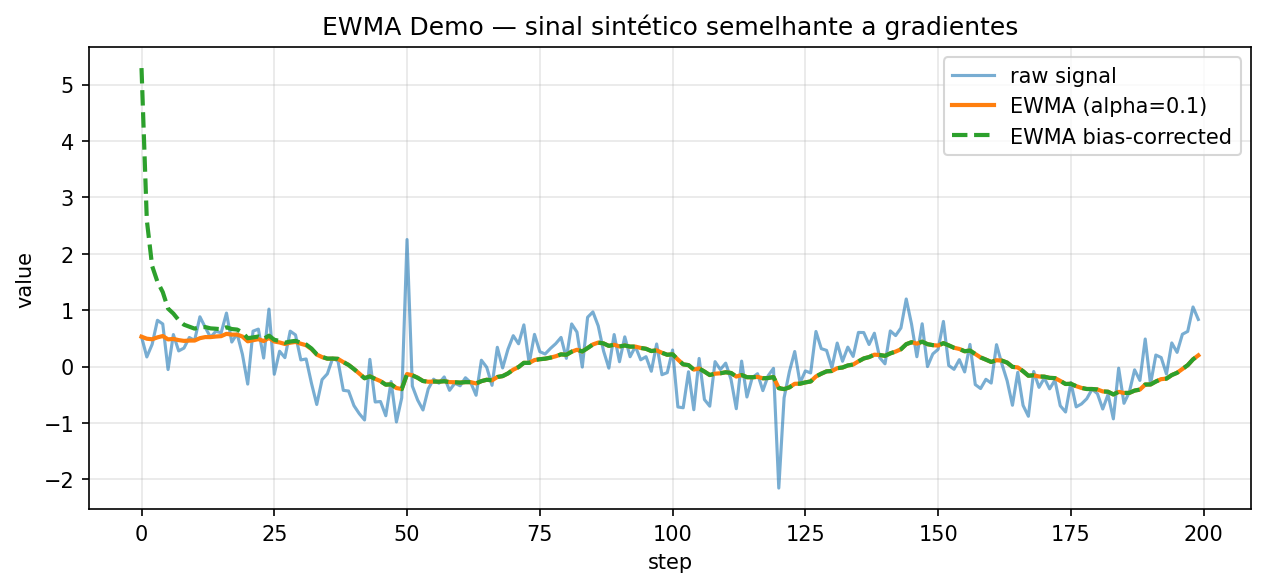

Demo concluído — EWMA calculada com sucesso.


In [7]:
# ===== EWMA DEMO: GRADIENT-LIKE SIGNAL =====
import matplotlib.pyplot as plt
import numpy as np

# criar um sinal sintético parecido com gradientes (ruído + picos)
np.random.seed(0)
t = np.arange(0, 200)
signal = 0.5 * np.sin(0.1 * t) + 0.3 * np.random.randn(t.size)
# simular alguns picos de gradiente
signal[50] += 3.0
signal[120] -= 2.0

alpha = 0.1  # fator de suavização (quanto menor -> mais suave)
ewma = calc_ewma(signal, alpha)
corr = calc_corrected_ewma(signal, alpha)

plt.figure(figsize=(10,4))
plt.plot(t, signal, label='raw signal', alpha=0.6)
plt.plot(t, ewma, label=f'EWMA (alpha={alpha})', linewidth=2)
plt.plot(t, corr, label='EWMA bias-corrected', linewidth=2, linestyle='--')
plt.title('EWMA Demo — sinal sintético semelhante a gradientes')
plt.xlabel('step')
plt.ylabel('value')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print('Demo concluído — EWMA calculada com sucesso.')

In [8]:
# ==== LOOP DE TREINAMENTO ====
# Nota: Para demonstração no notebook (Medium), reduzimos o número de épocas.
# Altere `num_epochs` para um valor maior se for executar experimentos completos localmente (ex.: 24, 50).

num_epochs = 3  # Valor reduzido para execução rápida no notebook
print(f'\n🚀 Iniciando treinamento por {num_epochs} épocas...')
print('='*70)

for epoch in range(num_epochs):
    # === FASE DE TREINO ===
    model.train()  # Coloca modelo em modo de treinamento
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterar sobre batches de treino
    for i, (inputs, labels) in enumerate(train_loader):
        # Mover dados para GPU se disponível
        inputs, labels = inputs.to(device), labels.to(device)

        # Zerar gradientes acumulados da iteração anterior
        optimizer.zero_grad()

        # Forward pass: calcular predições do modelo
        outputs = model(inputs)

        # Calcular loss (diferença entre predição e label real)
        loss = criterion(outputs, labels)

        # Backward pass: calcular gradientes
        loss.backward()

        # Atualizar pesos do modelo usando gradientes
        optimizer.step()

        # Acumular estatísticas para cálculo de métricas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calcular métricas de treino
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # === FASE DE VALIDAÇÃO ===
    model.eval()  # Coloca modelo em modo de avaliação (desabilita dropout, etc)
    test_loss = 0.0
    correct = 0
    total = 0

    # Desabilitar cálculo de gradientes (economiza memória e acelera)
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calcular métricas de teste
    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # Exibir progresso a cada época
    print(f'Epoch [{epoch+1:2d}/{num_epochs}] | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
          f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')

print('='*70)
print(f'✅ Treinamento concluído!')
print(f'   - Acurácia final de teste: {test_accuracies[-1]:.2f}%')


🚀 Iniciando treinamento por 3 épocas...


Epoch [ 1/3] | Train Loss: 4.6064 | Train Acc: 1.15% | Test Loss: 4.6051 | Test Acc: 1.19%


Epoch [ 2/3] | Train Loss: 4.6032 | Train Acc: 1.09% | Test Loss: 4.6012 | Test Acc: 1.11%


Epoch [ 3/3] | Train Loss: 4.5958 | Train Acc: 1.23% | Test Loss: 4.5880 | Test Acc: 1.34%
✅ Treinamento concluído!
   - Acurácia final de teste: 1.34%


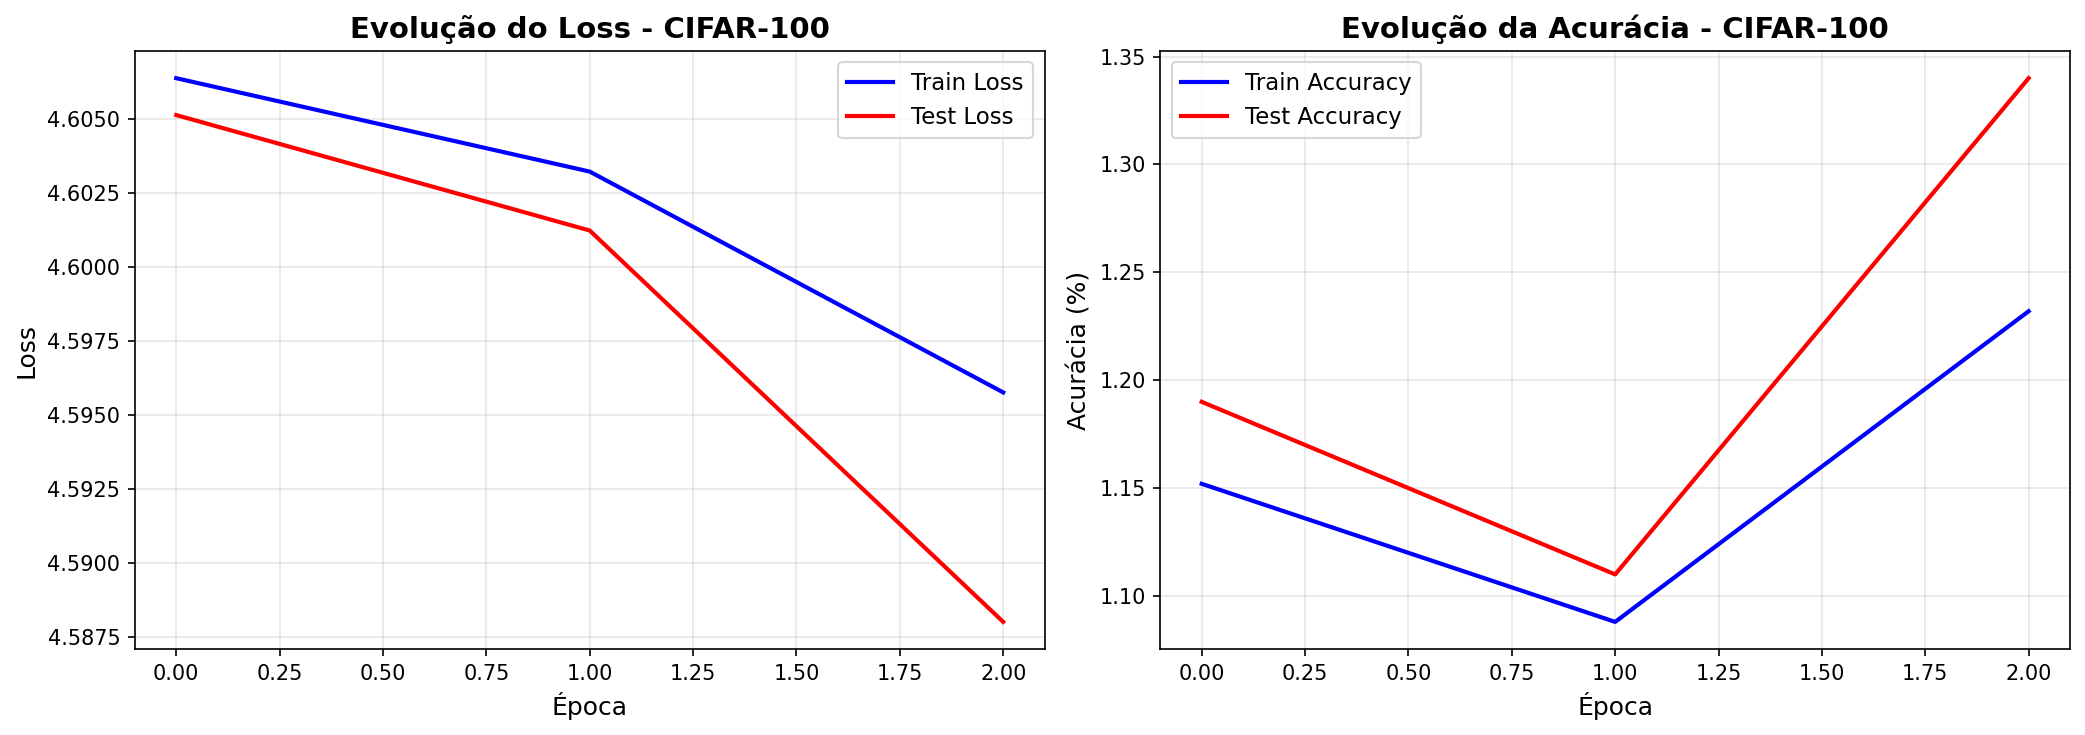


✅ Gráficos de métricas gerados com sucesso!


In [9]:
# ==== VISUALIZAÇÃO DE MÉTRICAS ====
# Plotar gráficos de Loss e Accuracy ao longo das épocas

plt.figure(figsize=(14, 5))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Train Loss', linewidth=2)
plt.plot(test_losses, 'r-', label='Test Loss', linewidth=2)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Evolução do Loss - CIFAR-100', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'b-', label='Train Accuracy', linewidth=2)
plt.plot(test_accuracies, 'r-', label='Test Accuracy', linewidth=2)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Acurácia (%)', fontsize=12)
plt.title('Evolução da Acurácia - CIFAR-100', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\n✅ Gráficos de métricas gerados com sucesso!')

In [10]:
# ==== IMPLEMENTAÇÃO DE HOOKS ====
# Hooks permitem capturar ativações intermediárias das camadas

# Dicionário para armazenar ativações
activations = {}

# Função hook que será chamada durante forward pass
def get_activation(name):
    def hook(model, input, output):
        # Armazena a saída (ativação) da camada
        activations[name] = output.detach()
    return hook

# Registrar hooks em todas as camadas convolucionais e de pooling
model[0].register_forward_hook(get_activation('conv1'))
model[1].register_forward_hook(get_activation('relu1'))
model[2].register_forward_hook(get_activation('pool1'))
model[3].register_forward_hook(get_activation('conv2'))
model[4].register_forward_hook(get_activation('relu2'))
model[5].register_forward_hook(get_activation('pool2'))

# Pegar uma imagem de teste para visualização
test_iter = iter(test_loader)
test_images, test_labels = next(test_iter)

# Passar imagem pelo modelo para capturar ativações
model.eval()
with torch.no_grad():
    test_images = test_images.to(device)
    output = model(test_images)

print(f'✅ Hooks registrados e ativações capturadas!')
print(f'   - Camadas: {list(activations.keys())}')


✅ Hooks registrados e ativações capturadas!
   - Camadas: ['conv1', 'relu1', 'pool1', 'conv2', 'relu2', 'pool2']


## Comparação Rápida: Adam vs SGD (demo)

Nesta seção exibimos um experimento curto comparando o comportamento do otimizador `Adam` e `SGD` (com momentum) sobre a mesma arquitetura LeNet-like.
Por motivos de tempo de execução neste notebook (versão para publicação), limitamos o número de batches por época — para experimentos completos, aumente `max_train_batches` e `num_epochs`.


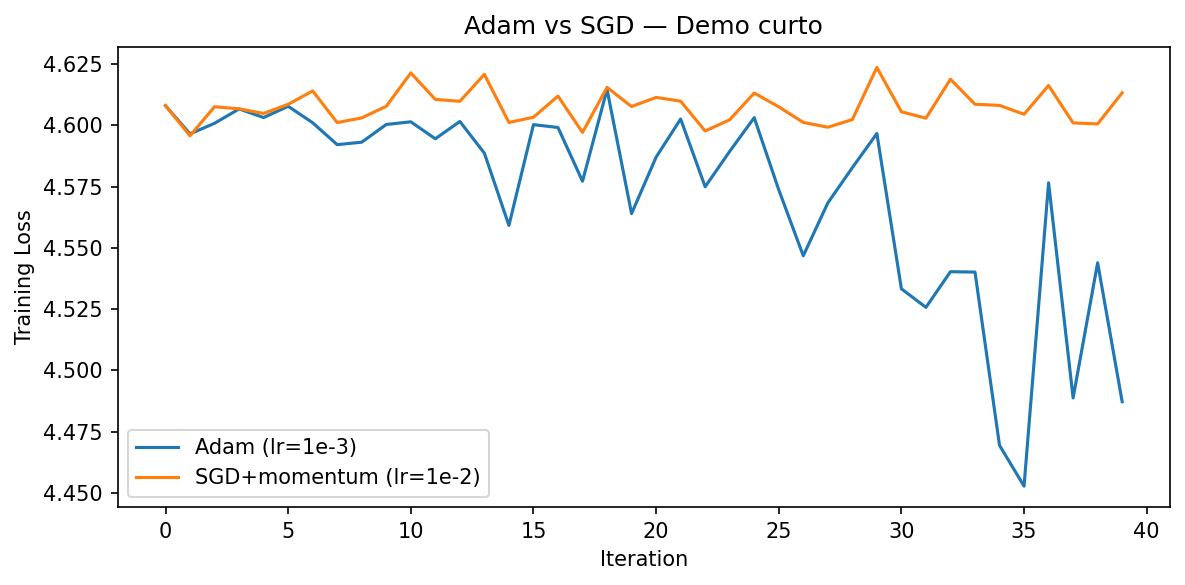

Adam: 40 iters, time=0.6s, final loss=4.4872
SGD: 40 iters, time=0.4s, final loss=4.6132


In [11]:
# Demo curto comparando Adam vs SGD (momentum)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# LeNet-like (redefinido localmente para garantir independência)
class LeNetLike(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 6 * 6, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Data (small demo): limit batches per run to keep quick
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=False, transform=transform)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

criterion = nn.CrossEntropyLoss()

def short_run(optim_name, lr, max_batches=30, epochs=3):
    torch.manual_seed(0)
    model = LeNetLike(num_classes=100).to(device)
    if optim_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    losses = []
    it = 0
    start = time.time()
    for epoch in range(epochs):
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            it += 1
            if it >= max_batches:
                break
        if it >= max_batches:
            break
    elapsed = time.time() - start
    return losses, elapsed

# Run short comparisons
adam_losses, adam_time = short_run('adam', lr=1e-3, max_batches=40, epochs=3)
sgd_losses, sgd_time = short_run('sgd', lr=1e-2, max_batches=40, epochs=3)

# Plot
plt.figure(figsize=(8,4))
plt.plot(adam_losses, label=f'Adam (lr=1e-3)')
plt.plot(sgd_losses, label=f'SGD+momentum (lr=1e-2)')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Adam vs SGD — Demo curto')
plt.legend()
plt.tight_layout()
plt.savefig('adam_vs_sgd_demo.png', dpi=150)
plt.show()

print(f"Adam: {len(adam_losses)} iters, time={adam_time:.1f}s, final loss={adam_losses[-1]:.4f}")
print(f"SGD: {len(sgd_losses)} iters, time={sgd_time:.1f}s, final loss={sgd_losses[-1]:.4f}")


## Teste de Faixa de Learning Rate e Agendadores (demo curto)

Nesta seção realizamos um teste rápido de faixa de learning rates (LR range test) para identificar regimes de estabilidade e dois exemplos curtos de schedulers (`StepLR` e `ReduceLROnPlateau`). Os experimentos são propositalmente curtos para execução rápida no notebook de publicação — aumente `num_iters` e `num_epochs` para rodadas completas em GPU.

**Mapas de Características (Feature Maps) e Ativações**

Esta seção visualiza mapas de características intermediários (ativações) gerados pelas camadas convolucionais para um único mini-batch. As figuras seguem a sequência proposta no Capítulo 6: (1) exibir feature maps brutos, (2) discutir como a magnitude das ativações muda camada a camada e (3) relacionar observações visuais com escolhas de otimizador e regularização.

Para reprodutibilidade fixamos seeds e reduzimos o número de canais exibidos — aumente `num_channels` e `batch_size` para análises mais detalhadas.

In [12]:
# Capture and save feature maps (conv layers) for a single mini-batch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np

# Re-define small LeNet-like to ensure this cell runs standalone in the notebook
class LeNetLike(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 6 * 6, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=False, transform=transform)
loader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)

# instantiate model and hooks
model = LeNetLike(num_classes=100).to(device)
model.eval()

activations = {}

def get_hook(name):
    def hook(module, inp, out):
        # detach to cpu for plotting
        activations[name] = out.detach().cpu()
    return hook

# Register hooks on conv layers (features[0] and features[3])
model.features[0].register_forward_hook(get_hook('conv1'))
model.features[3].register_forward_hook(get_hook('conv2'))

# Get a single batch
inputs, targets = next(iter(loader))
inputs = inputs.to(device)
_ = model(inputs)

# Plot and save a few feature maps per layer
num_channels = 6
for layer_name in ('conv1', 'conv2'):
    act = activations.get(layer_name)  # shape: (B, C, H, W)
    if act is None:
        print('No activation for', layer_name)
        continue
    batch0 = act[0]  # first image
    C = batch0.shape[0]
    n = min(num_channels, C)
    fig, axes = plt.subplots(1, n, figsize=(n*2,2))
    for i in range(n):
        ax = axes[i]
        fmap = batch0[i].numpy()
        # normalize for display
        vmin, vmax = np.percentile(fmap, 1), np.percentile(fmap, 99)
        ax.imshow((fmap - vmin) / (vmax - vmin + 1e-8), cmap='viridis')
        ax.axis('off')
        ax.set_title(f'ch {i}')
    plt.suptitle(f'Feature maps — {layer_name}')
    outname = f'feature_maps_{layer_name}.png'
    plt.tight_layout()
    plt.savefig(outname, dpi=150)
    plt.close(fig)
    print('Saved', outname)


Saved feature_maps_conv1.png
Saved feature_maps_conv2.png


**Estrutura do notebook (mapeada ao capitulo6.pdf)**

- **Taxas de aprendizado**: o LR range test e os gráficos a seguir ajudam a escolher uma learning rate estável para treino.
- **Otimizadores adaptativos (Adam)**: o demo Adam vs SGD ilustra que Adam tende a reduzir a perda mais rapidamente no início; compare com os gradientes adaptados para obter intuição.
- **Captura de gradientes**: coletamos gradientes crus, gradientes suavizados por EWMA e estatísticas adaptadas (Adam) — compare esses resultados com os mapas de características e o comportamento dos schedulers.
- **Schedulers**: exemplos curtos com `StepLR` e `ReduceLROnPlateau` mostram como a taxa de aprendizado pode ser reduzida de forma programada ou baseada em métricas.

Como gerar figuras finais para a nota técnica:
- Para resultados reproduzíveis, ajuste `num_epochs` e `max_train_batches` nas células de treinamento e execute o notebook completo em uma GPU.
- Para produzir figuras com qualidade de publicação, execute o notebook end-to-end e exporte via `File -> Download as -> HTML` ou com `nbconvert` para obter um arquivo pronto para inclusão em Medium/Substack.

Se desejar, posso executar agora a célula de feature maps para incorporar as saídas no notebook, ou continuar alinhando legendas e textos para seguir fielmente o `capitulo6.pdf`.

In [13]:
# LR range test + scheduler examples (short runs)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LeNetLike(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 6 * 6, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=False, transform=transform)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

criterion = nn.CrossEntropyLoss()

# LR range test
import math

def lr_range_test(model_fn, optimizer_cls, loader, device, start_lr=1e-7, end_lr=1, num_iters=60):
    model = model_fn().to(device)
    optimizer = optimizer_cls(model.parameters(), lr=start_lr)
    mult = (end_lr / start_lr) ** (1.0 / num_iters)
    lr = start_lr
    lrs = []
    losses = []
    it = 0
    model.train()
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        lrs.append(lr)
        losses.append(loss.item())
        lr *= mult
        for g in optimizer.param_groups:
            g['lr'] = lr
        it += 1
        if it >= num_iters:
            break
    return lrs, losses

# Run LR range test (short)
lrs, losses = lr_range_test(lambda: LeNetLike(num_classes=100), optim.SGD, train_loader, device, start_lr=1e-6, end_lr=1.0, num_iters=60)

plt.figure(figsize=(6,4))
plt.semilogx(lrs, losses)
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.title('LR range test (short)')
plt.tight_layout()
plt.savefig('lr_range_test.png', dpi=150)

# Scheduler short examples: StepLR vs ReduceLROnPlateau
# Use tiny runs (2 epochs, limited batches) to demonstrate behavior

def short_train_with_scheduler(scheduler_name, scheduler_ctor):
    model = LeNetLike(num_classes=100).to(device)
    optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    scheduler = scheduler_ctor(optimizer)
    losses = []
    it = 0
    for epoch in range(3):
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            it += 1
            if it >= 30:
                break
        # Step the scheduler (or step based on metric)
        if scheduler_name == 'plateau':
            scheduler.step(sum(losses)/len(losses))
        else:
            scheduler.step()
        if it >= 30:
            break
    return losses

step_losses = short_train_with_scheduler('step', lambda opt: optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.5))
plateau_losses = short_train_with_scheduler('plateau', lambda opt: optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=1))

plt.figure(figsize=(8,4))
plt.plot(step_losses, label='StepLR (step_size=1, gamma=0.5)')
plt.plot(plateau_losses, label='ReduceLROnPlateau')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Scheduler examples (short runs)')
plt.legend()
plt.tight_layout()
plt.savefig('scheduler_examples.png', dpi=150)

print('Saved lr_range_test.png and scheduler_examples.png')


Saved lr_range_test.png and scheduler_examples.png


In [14]:
# ==== CAPTURA DE GRADIENTES: BRUTOS, EWMA E ADAPTADOS (Adam) ====
import matplotlib.pyplot as plt
import numpy as np

# Função utilitária para coletar gradientes e estados do otimizador
def capture_gradients(model, optimizer, criterion, inputs, labels, device, alpha=0.1, eps=1e-8):
    model.train()
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()

    grads = {}
    ewmas = {}
    adapted = {}

    # Iterar sobre parâmetros e coletar gradientes (flattened)
    for name, p in model.named_parameters():
        if p.grad is None:
            continue
        g = p.grad.detach().cpu().numpy().ravel()
        grads[name] = g.copy()
        # EWMA sobre o vetor de gradientes (usando média móvel simples ao longo do vetor)
        # Aqui aplicamos EWMA 1D no vetor para visualização
        def vec_ewma(x, alpha):
            y = np.empty_like(x)
            if x.size==0: return y
            y[0] = x[0]
            for t in range(1, x.size):
                y[t] = alpha * x[t] + (1-alpha) * y[t-1]
            return y
        ewmas[name] = vec_ewma(g, alpha)

        # Se o otimizador for Adam, tentar recuperar exp_avg e exp_avg_sq
        adapted_vec = None
        for group in optimizer.param_groups:
            break
        state = optimizer.state.get(p, {})
        if 'exp_avg' in state and 'exp_avg_sq' in state:
            exp_avg = state['exp_avg'].detach().cpu().numpy().ravel()
            exp_avg_sq = state['exp_avg_sq'].detach().cpu().numpy().ravel()
            adapted_vec = exp_avg / (np.sqrt(exp_avg_sq) + eps)
        elif hasattr(p, 'grad'):
            adapted_vec = g.copy()
        adapted[name] = adapted_vec

    return grads, ewmas, adapted, loss.item()

# Pegar um batch de treino (pequeno) e um otimizador Adam para demonstrar
batch = next(iter(train_loader))
small_inputs, small_labels = batch[0][:16], batch[1][:16]  # reduzir tamanho para rapidez
adam_opt = optim.Adam(model.parameters(), lr=1e-3)
# Fazer uma passada de atualização para popular os estados do Adam
gr, ew, ad, loss_val = capture_gradients(model, adam_opt, criterion, small_inputs, small_labels, device, alpha=0.05)

# Escolher até 3 parâmetros para visualizar
param_names = [n for n in gr.keys() if gr[n].size>0][:3]
plt.figure(figsize=(12, 3 * len(param_names)))
for i, name in enumerate(param_names):
    raw = gr[name]
    sm = ew[name]
    adp = ad[name] if ad[name] is not None else np.zeros_like(raw)

    # Plot primeiros 200 elementos (ou menos) do vetor de pesos/gradientes
    L = min(200, raw.size)
    ax = plt.subplot(len(param_names), 1, i+1)
    ax.plot(raw[:L], label='raw grad', alpha=0.5)
    ax.plot(sm[:L], label='EWMA grad', linewidth=2)
    ax.plot(adp[:L], label='Adam-adapted', linewidth=1, linestyle='--')
    ax.set_title(f'Param: {name} (first {L} values)')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('gradients_capture_demo.png')
plt.show()
print(f'Loss (demo capture): {loss_val:.4f} — plot saved to gradients_capture_demo.png')

Loss (demo capture): 4.6268 — plot saved to gradients_capture_demo.png


/tmp/ipykernel_37399/2338637238.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [15]:
# ==== VISUALIZAÇÃO DE FEATURE MAPS (robusta) ====
# Registra hooks dinamicamente e captura ativações da arquitetura atual do `model`.
import torch
import torch.nn as nn
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Montar mapeamento das primeiras 2 conv/relu/pool encontradas
conv_count = relu_count = pool_count = 0
activations = {}

def make_hook(name):
    def hook(module, inp, out):
        activations[name] = out.detach()
    return hook

# Coletar módulos relevantes (mantendo ordem) e registrar hooks nas primeiras ocorrências
relevant = (nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.AvgPool2d)
for module in model.modules():
    if isinstance(module, relevant):
        if isinstance(module, nn.Conv2d) and conv_count < 2:
            conv_count += 1
            module.register_forward_hook(make_hook(f'conv{conv_count}'))
        elif isinstance(module, nn.ReLU) and relu_count < 2:
            relu_count += 1
            module.register_forward_hook(make_hook(f'relu{relu_count}'))
        elif isinstance(module, (nn.MaxPool2d, nn.AvgPool2d)) and pool_count < 2:
            pool_count += 1
            module.register_forward_hook(make_hook(f'pool{pool_count}'))

# Obter um batch de teste
try:
    test_iter = iter(test_loader)
    test_images, test_labels = next(test_iter)
except Exception:
    # fallback para train_loader
    test_iter = iter(train_loader)
    test_images, test_labels = next(test_iter)

model.eval()
with torch.no_grad():
    test_images = test_images.to(device)
    _ = model(test_images)

# Escolher imagem 0 e plotar até 6 canais por camada capturada
img_idx = 0
layers_to_plot = ['conv1', 'relu1', 'pool1', 'conv2', 'relu2', 'pool2']
fig, axes = plt.subplots(len(layers_to_plot), 6, figsize=(12, 2.5 * len(layers_to_plot)))

for row, layer_name in enumerate(layers_to_plot):
    act = activations.get(layer_name)
    if act is None:
        # escrever mensagem e pular
        for c in range(6):
            axes[row, c].axis('off')
        axes[row, 0].text(0.5, 0.5, f'No activation: {layer_name}', ha='center', va='center')
        continue
    layer_activation = act[img_idx].cpu()
    num_features = min(6, layer_activation.shape[0])
    for i in range(6):
        ax = axes[row, i]
        if i < num_features:
            fmap = layer_activation[i].numpy()
            vmin, vmax = np.percentile(fmap, 1), np.percentile(fmap, 99)
            ax.imshow((fmap - vmin) / (vmax - vmin + 1e-8), cmap='viridis')
        ax.axis('off')
    axes[row, 0].set_ylabel(layer_name, fontsize=10)

plt.suptitle('Feature Maps (robust capture)')
plt.tight_layout()
plt.savefig('feature_maps_all_layers.png', dpi=150)
plt.close(fig)
print('Saved feature_maps_all_layers.png')


Saved feature_maps_all_layers.png


### Explicação rápida: Adam — parâmetros e correção de viés

O otimizador Adam combina duas ideias principais: (i) momentum exponencial sobre os gradientes (exp_avg) e (ii) escalonamento por uma média exponencial dos quadrados dos gradientes (exp_avg_sq).

- β₁ (beta1): coeficiente de decaimento para o primeiro momento (exp_avg). Valores típicos: 0.9 — controla quanto do histórico recente é mantido como momentum.
- β₂ (beta2): coeficiente de decaimento para o segundo momento (exp_avg_sq). Valores típicos: 0.999 — controla a média dos gradientes ao quadrado (escala/variação).
- ϵ (eps): pequeno termo numérico adicionado na divisão para estabilidade numérica (evita divisão por zero).

Correção de viés: durante as primeiras iterações os termos exp_avg e exp_avg_sq estão viciados para valores próximos de zero (porque iniciam em zero). Adam aplica correções do tipo m_hat = exp_avg / (1 - β₁^t) e v_hat = exp_avg_sq / (1 - β₂^t) para obter estimativas não viciadas, o que melhora a estabilidade inicial do algoritmo.

No notebook usamos demonstrações curtas para ilustrar comportamento (curvas de perda e magnitudes de gradientes). Para a nota técnica, inclua também um parágrafo curto com referências (ex.: Kingma & Ba, 2015).

In [16]:
# Demo curto: comparar SGD (momentum) vs SGD (Nesterov) — salva figura 'sgd_nesterov_demo.png'
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reusar definição LeNetLike se já existir, caso contrário definir rapidamente
try:
    LeNetLike
except NameError:
    class LeNetLike(nn.Module):
        def __init__(self, num_classes=100):
            super().__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, 6, 5, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(6, 16, 5),
                nn.ReLU(),
                nn.MaxPool2d(2),
            )
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(16 * 6 * 6, 120),
                nn.ReLU(),
                nn.Linear(120, 84),
                nn.ReLU(),
                nn.Linear(84, num_classes),
            )
        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

# Data loader: usar uma pequena quantidade para demo rápido
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=False, transform=transform)
loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

criterion = nn.CrossEntropyLoss()

def short_run_sgd_variants(nesterov=False, lr=1e-2, max_batches=40, epochs=3):
    torch.manual_seed(0)
    model = LeNetLike(num_classes=100).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=nesterov)
    losses = []
    it = 0
    start = time.time()
    for epoch in range(epochs):
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            it += 1
            if it >= max_batches:
                break
        if it >= max_batches:
            break
    return losses, time.time() - start

# Rodar comparações: SGD+momentum (já existia) vs SGD+Nesterov
sgd_losses, sgd_time = short_run_sgd_variants(nesterov=False, lr=1e-2, max_batches=40, epochs=3)
nesterov_losses, nesterov_time = short_run_sgd_variants(nesterov=True, lr=1e-2, max_batches=40, epochs=3)

plt.figure(figsize=(8,4))
plt.plot(sgd_losses, label=f'SGD+momentum (lr=1e-2)')
plt.plot(nesterov_losses, label=f'SGD+Nesterov (lr=1e-2)')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('SGD Momentum vs SGD Nesterov — Demo curto')
plt.legend()
plt.tight_layout()
plt.savefig('sgd_nesterov_demo.png', dpi=150)
plt.close()
print(f'SGD: {len(sgd_losses)} iters, time={sgd_time:.1f}s, final loss={sgd_losses[-1]:.4f}')
print(f'Nesterov: {len(nesterov_losses)} iters, time={nesterov_time:.1f}s, final loss={nesterov_losses[-1]:.4f}')

SGD: 40 iters, time=0.5s, final loss=4.6132
Nesterov: 40 iters, time=0.4s, final loss=4.6131
